# Imbalanced classification

## By: Rotem Klein 

$$ $$
In this project, I will present a classification of unbalanced data.
$$ $$
The dataset contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred during two days. 
It contains only numerical input variables which are the result of a PCA transformation.
The provided data does not include all the original features due to confidential issues. Features V1, V2, … V28 are the principal components obtained with PCA. 
The only features which have not been transformed with PCA are 'Time' and 'Amount'. 
The feature 'Time' measures the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount. 
The feature 'Class' is the response variable: 1 marks fraud, while 0 is otherwise. 
$$ $$
The dataset was taken from Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud
(I will use the first 152,286 rows of the data).

In [28]:
# importing relevant libraries
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from imblearn import under_sampling, over_sampling

import seaborn as sns
import matplotlib.pyplot as plt
import random

random.seed(123)

## The Data

In [29]:
df = pd.read_csv('.\creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,168693.0,-2.410025,-1.432871,1.373919,-2.507625,-1.697742,-0.544289,-1.293413,0.849440,-2.024631,...,0.044517,-0.026928,-0.232544,-0.100905,0.384982,-0.207308,-0.205183,-0.327786,101.96,0
1,118549.0,-0.233408,0.836979,-0.213454,-1.449573,0.997381,-0.992416,1.261875,-0.367021,0.394419,...,0.324950,1.393384,-0.248714,-0.313350,-0.572191,-0.621261,0.443084,0.149534,5.81,0
2,76258.0,1.352543,-1.074605,-0.025568,-1.529348,-0.888643,-0.040194,-0.774928,0.091264,-2.318066,...,-0.410819,-0.921721,0.204471,-0.373019,0.085152,-0.438247,0.024120,0.003700,44.95,0
3,36474.0,-4.564317,-4.877094,1.407992,0.780386,-0.120295,-0.408491,-0.736098,1.032603,-1.165996,...,0.410231,-0.735606,1.074129,-0.118351,0.309854,-0.499497,-0.134161,-0.519133,533.76,0
4,142785.0,0.477111,0.880224,-0.153527,0.940528,0.769459,-0.392702,0.670287,-0.299183,-0.608578,...,0.426408,1.490050,-0.102636,0.767108,-0.931175,0.123492,0.316876,0.276006,1.29,0


In [30]:
# deleting 'Time' column
df = df.drop(['Time'], axis = 1)

In [31]:
negative, positive = np.bincount(df['Class'])
total = negative + positive
print('Positive = ',(positive))
print('Negative = ',(negative))
print('Total = ',(total))
print('The amount of frauds = ', round(100 * (positive/total), 3))

Positive =  268
Negative =  152017
Total =  152285
The amount of frauds =  0.176


We can see that we have 268 frauds out of 152,285 transactions. The dataset is highly unbalanced, 
the positive class (frauds) account for 0.176% of all transactions.

#### Descriptive statistics

In [32]:
col_names_list = df.columns
df[col_names_list].describe(include = 'all')

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,152285.000000,152285.000000,152285.000000,152285.000000,152285.000000,152285.000000,152285.000000,152285.000000,152285.000000,152285.000000,...,152285.000000,152285.000000,152285.000000,152285.000000,152285.000000,152285.000000,152285.000000,152285.000000,152285.000000,152285.000000
mean,-0.004710,0.004252,0.001579,0.003643,0.002949,-0.001981,-0.000596,-0.000516,-0.001362,-0.001005,...,0.000930,0.002630,0.001341,-0.000263,0.000150,-0.000468,0.000529,0.000128,87.535348,0.001760
std,1.960674,1.641960,1.512732,1.415187,1.355291,1.321258,1.213399,1.212863,1.100374,1.085628,...,0.748053,0.727481,0.628942,0.605558,0.521585,0.481419,0.401711,0.321064,237.597113,0.041914
min,-46.855047,-45.607973,-33.680984,-5.683171,-42.147898,-20.367836,-43.557242,-50.943369,-13.434066,-24.588262,...,-22.889347,-8.887017,-44.807735,-2.822384,-10.295397,-2.068561,-22.565679,-11.710896,0.000000,0.000000
25%,-0.921757,-0.595486,-0.887493,-0.843627,-0.688859,-0.772012,-0.551135,-0.209217,-0.645360,-0.534749,...,-0.227357,-0.538765,-0.161813,-0.354871,-0.316115,-0.326837,-0.070460,-0.053049,5.560000,0.000000
50%,0.010337,0.067106,0.180365,-0.015499,-0.053044,-0.274148,0.042348,0.023187,-0.052806,-0.093723,...,-0.028311,0.010025,-0.010913,0.040747,0.017111,-0.051857,0.001490,0.011465,22.000000,0.000000
75%,1.313572,0.807517,1.028232,0.745813,0.614059,0.398029,0.569153,0.328011,0.594646,0.452450,...,0.187179,0.530444,0.147779,0.439801,0.351508,0.240716,0.091538,0.078485,77.700000,0.000000
max,2.454930,22.057729,9.382558,13.143668,29.162172,22.529298,36.877368,19.587773,15.594995,23.745136,...,27.202839,8.361985,20.803344,4.022866,5.852484,3.517346,12.152401,16.129609,12910.930000,1.000000


## Statistical model

### Splitting the data to train & test

In [33]:
# shuffle the data
df = shuffle(df)
num_samples = df.shape[0]

# 80% train, 20% test
train_frac = int(num_samples * 0.8)
train, test = df.iloc[:train_frac, :], df.iloc[train_frac:, :]

In [34]:
(_, train_zero), (_, train_one) = train.groupby('Class')

### Class 0 (not fraud) distribution:

In [35]:
label_0_dist = train_zero.describe()
label_0_dist

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,121616.000000,121616.000000,121616.000000,121616.000000,121616.000000,121616.000000,121616.000000,121616.000000,121616.000000,121616.000000,...,121616.000000,121616.000000,121616.000000,121616.000000,121616.000000,121616.000000,121616.000000,121616.000000,121616.000000,121616.0
mean,0.005161,0.000284,0.015587,-0.003917,0.009664,-0.000774,0.012027,0.000526,0.001844,0.008307,...,-0.001005,0.003002,0.001981,0.000268,0.000352,-0.001267,-0.000941,0.000456,87.335427,0.0
std,1.927544,1.622734,1.460001,1.398374,1.330945,1.318491,1.149657,1.160369,1.090397,1.041001,...,0.716464,0.723863,0.622963,0.605017,0.520426,0.481274,0.400767,0.324441,237.049414,0.0
min,-46.855047,-45.607973,-33.680984,-5.683171,-35.182120,-20.367836,-24.419483,-50.943369,-6.105803,-11.152891,...,-22.889347,-8.454599,-36.666000,-2.822384,-6.712624,-2.068561,-22.565679,-11.710896,0.000000,0.0
25%,-0.916669,-0.595672,-0.880688,-0.843307,-0.684154,-0.770706,-0.545683,-0.209295,-0.644249,-0.533660,...,-0.227103,-0.537810,-0.161907,-0.353514,-0.315101,-0.326947,-0.070378,-0.053101,5.577500,0.0
50%,0.010599,0.066815,0.185037,-0.020225,-0.049921,-0.274322,0.045790,0.022647,-0.053077,-0.093262,...,-0.028150,0.010858,-0.010929,0.041082,0.017475,-0.052864,0.001342,0.011365,21.990000,0.0
75%,1.314305,0.805278,1.033979,0.740843,0.614687,0.395465,0.570941,0.326916,0.593543,0.455401,...,0.186407,0.529612,0.147199,0.439535,0.351316,0.238541,0.090874,0.078208,77.572500,0.0
max,2.454930,18.902453,9.382558,13.143668,29.162172,21.550496,36.877368,18.282168,15.594995,23.745136,...,22.580675,7.357255,20.803344,4.016342,5.852484,3.517346,12.152401,16.129609,12910.930000,0.0


### Class 1 (fraud) distribution:

In [36]:
label_1_dist = train_one.describe()
label_1_dist

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,...,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.0
mean,-4.787576,3.645693,-6.971530,4.604513,-2.960444,-1.320098,-5.627483,-0.173757,-2.709766,-5.727209,...,0.781375,-0.033766,0.015662,-0.146485,0.009913,0.033507,0.153921,0.064677,130.485519,1.0
std,6.732753,4.582027,7.048063,2.955195,5.391839,2.041202,7.763034,7.995532,2.641220,5.238381,...,4.841540,1.780905,1.661504,0.510059,0.743301,0.455721,1.440958,0.534799,271.380725,0.0
min,-28.709229,-8.402154,-30.177317,-1.313275,-20.786000,-5.773192,-43.557242,-41.044261,-13.434066,-24.588262,...,-22.797604,-8.887017,-15.981649,-1.632653,-3.536716,-1.152671,-7.263482,-1.796363,0.000000,1.0
25%,-5.982945,1.131445,-9.451703,2.333844,-4.762439,-2.453379,-8.151490,-0.290129,-3.961676,-7.628187,...,-0.010842,-0.516574,-0.330472,-0.468433,-0.303762,-0.279688,-0.019328,-0.130715,1.000000,1.0
50%,-2.330783,2.936182,-5.078734,4.306272,-1.340725,-1.423506,-3.048985,0.518277,-2.294228,-4.493399,...,0.657190,-0.070710,-0.061527,-0.157380,0.042695,-0.021723,0.386073,0.130957,7.785000,1.0
75%,-0.643006,5.244990,-2.095795,6.459129,0.328965,-0.389844,-0.728570,1.764879,-0.761342,-2.235067,...,1.244611,0.585283,0.318421,0.254836,0.444596,0.397270,0.799780,0.381152,120.475000,1.0
max,1.934946,22.057729,2.250210,11.906170,11.095089,6.474115,5.431271,18.748872,1.992110,2.688670,...,27.202839,8.361985,5.466230,0.901260,2.051687,1.246604,2.706566,1.779364,2125.870000,1.0


I assume that the data is distributed in a multivariate normal distribution. 
The data belonging to class 0 are normally distributed with mean and standard deviation 
and the data belonging to class 1 are normally distributed with different mean and standard deviation.

In [37]:
# Normal density function
def calc_prob(mean, std, value):
    mul = 1/(std * np.sqrt(np.pi * 2))
    exponent = -(value - mean) ** 2.0 / (2 * std ** 2.0)
    return mul * np.exp(exponent)

# The classifier takes each value obtained in a test set and checks its probability in a normal density function
# with the same mean and standard deviation that belong to the value,
# and checks if the value belongs to the normal distribution of the class from which it is actually classified.

def predict(entry):
    label_0_prob = 1
    label_1_prob = 1
    for i in range(1, 29):
        v_i = 'V' + str(i)
        entry_v_i = entry[v_i]
        mean_label_0 = label_0_dist.at['mean', v_i]
        std_label_0 = label_0_dist.at['std', v_i]
        prob_label_0_v_i = calc_prob(mean_label_0, std_label_0, entry_v_i)
        label_0_prob *= prob_label_0_v_i
        
        
        mean_label_1 = label_1_dist.at['mean', v_i]
        std_label_1 = label_1_dist.at['std', v_i]
        prob_label_1_v_i = calc_prob(mean_label_1, std_label_1, entry_v_i)
        label_1_prob *= prob_label_1_v_i
    return 0 if label_0_prob > label_1_prob else 1

real_label = []
predicted_label = []
for i in range(len(test)):
    entry = test.iloc[i, :]
    real_label.append(entry['Class'])
    predicted_label.append(predict(entry))    

,Accuracy,AUC & ROC
Statistical Model,0.973,0.897


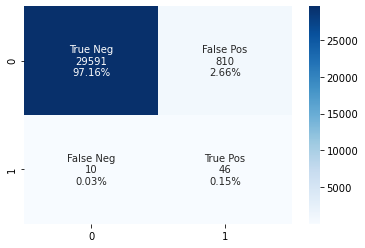

In [38]:
cf_matrix = confusion_matrix(real_label, predicted_label)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
stat_mod_accuracy = round(accuracy_score(real_label, predicted_label), 3)
stat_mod_ROC = round(sklearn.metrics.roc_auc_score(real_label, predicted_label),3)
pd.DataFrame([stat_mod_accuracy, stat_mod_ROC], index=['Accuracy', 'AUC & ROC'], columns=['Statistical Model']).T

The results show a very high accuracy (97%) of the model and a high AUC & ROC score (89%), it seems that the classification is close to reality.

## Undersampling and oversampling

Since the data is unbalanced, I wanted to examine how the accuracy metrics change when performing undersampling 
and oversampling of the data. 

So I ran each of the following algorithms on 3 data types:
1. The original data
2. Undersampling data
3. Oversampling data

In [39]:
class_count_0, class_count_1 = df['Class'].value_counts()
class_0 = df[df['Class'] == 0]
class_1 = df[df['Class'] == 1]

# under-sampling:
class_0_under = class_0.sample(class_count_1)
test_under = pd.concat([class_0_under, class_1], axis=0)
print("Total class of 1 and 0:" , test_under['Class'].value_counts())

Total class of 1 and 0: 0    268
1    268
Name: Class, dtype: int64


In [40]:
# over-sampling:
class_1_over = class_1.sample(class_count_0, replace=True)
test_over = pd.concat([class_1_over, class_0], axis=0)

print("Total class of 1 and 0:", test_over['Class'].value_counts())

Total class of 1 and 0: 0    152017
1    152017
Name: Class, dtype: int64


In [41]:
# train & test for undersampling and oversampling
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(test_under[test_under.columns.difference(['Class'])], test_under['Class'], test_size = 0.2)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(test_over[test_over.columns.difference(['Class'])], test_over['Class'], test_size = 0.2)

## Implementing Statistical Learning Algorithms

#### Logistic Regression

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns.difference(['Class'])], df['Class'], test_size = 0.2)

In [43]:
param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 1.25, 1.5]}
LR = LogisticRegression(solver='lbfgs', max_iter=10000)
LR_cv = GridSearchCV(LR, param_grid, cv = 5)
LR_cv.fit(X_train, y_train)

y_pred = LR_cv.predict(X_test)


LR_accuracy = round(accuracy_score(y_test, y_pred), 3)
LR_AUC_ROC = round(sklearn.metrics.roc_auc_score(y_test, y_pred),3)
pd.DataFrame([LR_accuracy, LR_AUC_ROC], index=['Accuracy', 'AUC & ROC'], columns=['Logistic Regression Metrics']).T

,Accuracy,AUC & ROC
Logistic Regression Metrics,0.999,0.818


In [44]:
pd.DataFrame.from_dict(LR_cv.best_params_, orient='index', columns=['Selected Parameter']).T

,C
Selected Parameter,1.25


<AxesSubplot:>

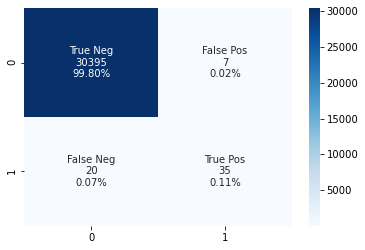

In [45]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

The results of the original data show an accuracy of 99% and an AUC & ROC score of 81%.

#### Under-sampling:

In [46]:
LR_under = LogisticRegression(solver='lbfgs', max_iter=10000)
LR_cv_under = GridSearchCV(LR_under, param_grid, cv = 5)
LR_cv_under.fit(X_train_under, y_train_under)
y_pred_under = LR_cv_under.predict(X_test_under)

LR_under_accuracy = round(accuracy_score(y_test_under, y_pred_under), 3)
LR_under_AUC_ROC = round(sklearn.metrics.roc_auc_score(y_test_under, y_pred_under),3)
pd.DataFrame([LR_under_accuracy, LR_under_AUC_ROC], index=['Accuracy', 'AUC & ROC'], columns=['Logistic Regression Metrics']).T

,Accuracy,AUC & ROC
Logistic Regression Metrics,0.917,0.919


In [47]:
pd.DataFrame.from_dict(LR_cv_under.best_params_, orient='index', columns=['Selected Parameter']).T

,C
Selected Parameter,1.25


<AxesSubplot:>

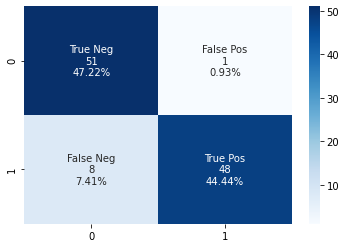

In [48]:
cf_matrix = confusion_matrix(y_test_under, y_pred_under)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


The results of the under-sampling data show an accuracy of 91% and an AUC & ROC score of 91%.

#### Over-sampling:

In [50]:
LR_over = LogisticRegression(solver='lbfgs', max_iter=10000)
LR_cv_over = GridSearchCV(LR_over, param_grid, cv = 5)
LR_cv_over.fit(X_train_over, y_train_over)
y_pred_over = LR_cv_over.predict(X_test_over)

LR_over_accuracy = round(accuracy_score(y_test_over, y_pred_over), 3)
LR_over_AUC_ROC = round(sklearn.metrics.roc_auc_score(y_test_over, y_pred_over),3)
pd.DataFrame([LR_over_accuracy, LR_over_AUC_ROC], index=['Accuracy', 'AUC & ROC'], columns=['Logistic Regression Metrics']).T

,Accuracy,AUC & ROC
Logistic Regression Metrics,0.943,0.943


In [51]:
pd.DataFrame.from_dict(LR_cv_over.best_params_, orient='index', columns=['Selected Parameter']).T

,C
Selected Parameter,0.05


<AxesSubplot:>

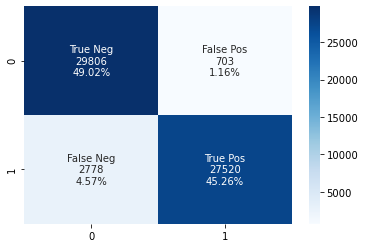

In [52]:
cf_matrix = confusion_matrix(y_test_over, y_pred_over)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


The results of the over-sampling data show the same accuracy score and AUC & ROC of 94%.

#### SVM

In [53]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

SVM_accuracy = round(accuracy_score(y_test, y_pred), 3)
SVM_AUC_ROC = round(sklearn.metrics.roc_auc_score(y_test, y_pred),3)
pd.DataFrame([SVM_accuracy, SVM_AUC_ROC], index=['Accuracy', 'AUC & ROC'], columns=['SVM']).T

,Accuracy,AUC & ROC
SVM,0.998,0.627


<AxesSubplot:>

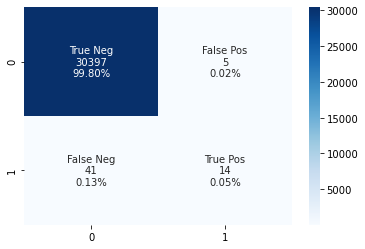

In [54]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

The results of the original data show accuracy score of 99% and AUC & ROC score of 62%.

#### Under-sampling:

In [55]:
svc = SVC()
svc.fit(X_train_under, y_train_under)
y_pred_under = svc.predict(X_test_under)

SVM_under_accuracy = round(accuracy_score(y_test_under, y_pred_under), 3)
SVM_under_AUC_ROC = round(sklearn.metrics.roc_auc_score(y_test_under, y_pred_under),3)
pd.DataFrame([SVM_under_accuracy, SVM_under_AUC_ROC], index=['Accuracy', 'AUC & ROC'], columns=['SVM']).T

,Accuracy,AUC & ROC
SVM,0.741,0.749


<AxesSubplot:>

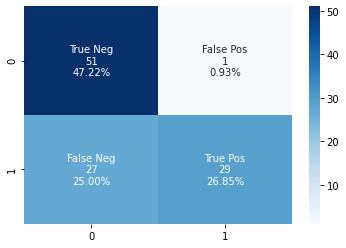

In [56]:
cf_matrix = confusion_matrix(y_test_under, y_pred_under)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

The results show a relatively close score in accuracy (74%) and in the AUC & ROC score (74%).

#### Over-sampling

In [57]:
svc = SVC()
svc.fit(X_train_over, y_train_over)
y_pred_over = svc.predict(X_test_over)

SVM_over_accuracy = round(accuracy_score(y_test_over, y_pred_over), 3)
SVM_over_AUC_ROC = round(sklearn.metrics.roc_auc_score(y_test_over, y_pred_over),3)
pd.DataFrame([SVM_over_accuracy, SVM_over_AUC_ROC], index=['Accuracy', 'AUC & ROC'], columns=['SVM']).T

,Accuracy,AUC & ROC
SVM,0.946,0.945


<AxesSubplot:>

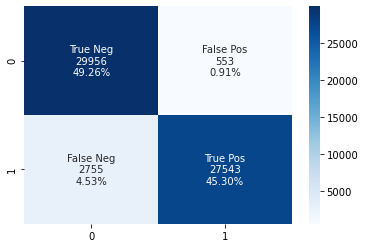

In [58]:
cf_matrix = confusion_matrix(y_test_over, y_pred_over)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

The results show the same score in accuracy (94%) and in the AUC & ROC score (94%)


#### Random Forest

In [59]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

RF_accuracy = round(accuracy_score(y_test, y_pred), 3)
RF_AUC_ROC = round(sklearn.metrics.roc_auc_score(y_test, y_pred),3)
pd.DataFrame([RF_accuracy, RF_AUC_ROC], index=['Accuracy', 'AUC & ROC'], columns=['Random Forest Accuracy']).T

,Accuracy,AUC & ROC
Random Forest Accuracy,0.999,0.818


<AxesSubplot:>

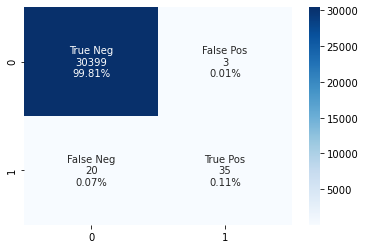

In [60]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

The results show a higher score in accuracy (99%) and in the AUC & ROC score (81%)

#### Under-sampling

In [61]:
rf = RandomForestClassifier()
rf.fit(X_train_under, y_train_under)
y_pred_under = rf.predict(X_test_under)

RF_under_accuracy = round(accuracy_score(y_test_under, y_pred_under), 3)
RF_under_AUC_ROC = round(sklearn.metrics.roc_auc_score(y_test_under, y_pred_under),3)
pd.DataFrame([RF_under_accuracy, RF_under_AUC_ROC], index=['Accuracy', 'AUC & ROC'], columns=['Random Forest Accuracy']).T

,Accuracy,AUC & ROC
Random Forest Accuracy,0.917,0.919


<AxesSubplot:>

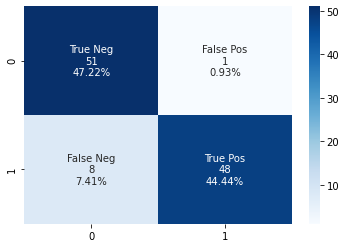

In [62]:
cf_matrix = confusion_matrix(y_test_under, y_pred_under)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

The results show a higher score in accuracy (91%) and in the AUC & ROC score (91%)

#### Over-sampling

In [63]:
rf = RandomForestClassifier()
rf.fit(X_train_over, y_train_over)
y_pred_over = rf.predict(X_test_over)

RF_over_accuracy = round(accuracy_score(y_test_over, y_pred_over), 3)
RF_over_AUC_ROC = round(sklearn.metrics.roc_auc_score(y_test_over, y_pred_over),3)
pd.DataFrame([RF_over_accuracy, RF_over_AUC_ROC], index=['Accuracy', 'AUC & ROC'], columns=['Random Forest Accuracy']).T

,Accuracy,AUC & ROC
Random Forest Accuracy,1.0,1.0


<AxesSubplot:>

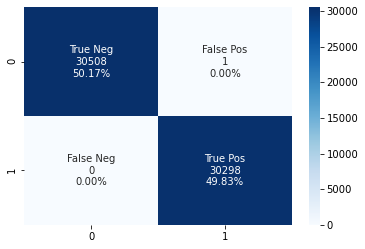

In [64]:
cf_matrix = confusion_matrix(y_test_over, y_pred_over)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

The results show a perfect classification in accuracy (100%) and in the AUC & ROC score (100%)

#### Gradient Tree Boosting

In [65]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

GB_accuracy = round(accuracy_score(y_test, y_pred), 3)
GB_AUC_ROC = round(sklearn.metrics.roc_auc_score(y_test, y_pred),3)
pd.DataFrame([GB_accuracy, GB_AUC_ROC], index=['Accuracy', 'AUC & ROC'], columns=['Gradient Tree Boosting']).T

,Accuracy,AUC & ROC
Gradient Tree Boosting,0.998,0.836


<AxesSubplot:>

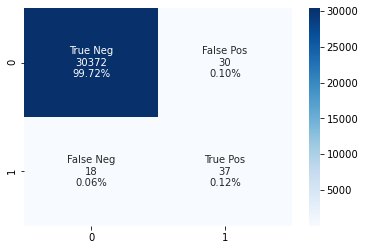

In [66]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

The results show a higher score in accuracy (99%) and in AUC & ROC score (83%)

#### Under-sampling

In [67]:
gb = GradientBoostingClassifier()
gb.fit(X_train_under, y_train_under)
y_pred_under = gb.predict(X_test_under)

GB_under_accuracy = round(accuracy_score(y_test_under, y_pred_under), 3)
GB_under_AUC_ROC = round(sklearn.metrics.roc_auc_score(y_test_under, y_pred_under),3)
pd.DataFrame([GB_under_accuracy, GB_under_AUC_ROC], index=['Accuracy', 'AUC & ROC'], columns=['Gradient Tree Boosting']).T

,Accuracy,AUC & ROC
Gradient Tree Boosting,0.907,0.91


<AxesSubplot:>

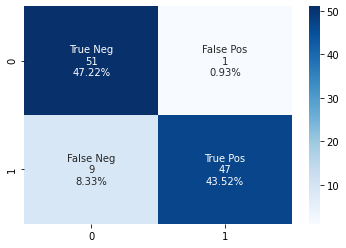

In [68]:
cf_matrix = confusion_matrix(y_test_under, y_pred_under)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

The results show a high score in accuracy (90%) and in AUC & ROC score (91%)

#### Over-sampling:

In [75]:
gb = GradientBoostingClassifier()
gb.fit(X_train_over, y_train_over)
y_pred_over = gb.predict(X_test_over)

GB_over_accuracy = round(accuracy_score(y_test_over, y_pred_over), 3)
GB_over_AUC_ROC = round(sklearn.metrics.roc_auc_score(y_test_over, y_pred_over),3)
pd.DataFrame([GB_under_accuracy, GB_under_AUC_ROC], index=['Accuracy', 'AUC & ROC'], columns=['Gradient Tree Boosting']).T

,Accuracy,AUC & ROC
Gradient Tree Boosting,0.907,0.91


<AxesSubplot:>

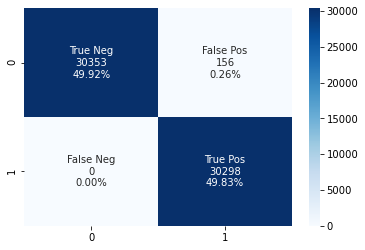

In [76]:
cf_matrix = confusion_matrix(y_test_over, y_pred_over)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

The results show a high score in accuracy (90%) and in AUC & ROC score (91%)

## Summary and Conclusions

In conclusion, it seems that the data is distributed in a multivariate normal distribution or very close to it.
The algorithm with the highest score is Random Forest.
In addition it seems that when over-sampling the data, the level of accuracy in the classification increased.